# Introduction

This project focuses on constructing a Naïve Bayes sentiment classifier to gauge the sentiment of movie reviews, specifically targeting positive and negative opinions. Using the polarity dataset v2.0 sourced from Cornell University, which consists of 1000 positive and 1000 negative reviews, we aim to build a model that accurately classifies reviews based on sentiment. To prepare the raw text data for classification, various preprocessing techniques will be applied, such as removing punctuation, filtering out stop words, and standardizing text. This project not only demonstrates the implementation of a Naïve Bayes classifier but also highlights the importance of text preprocessing in creating a reliable sentiment analysis model.

# import lib

In [ ]:
import os
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import requests

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
# Downloading NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Load

In [ ]:
# Defining paths to positive and negative reviews
pos_path = 'https://github.com/Vedant278/DAV-6150/tree/ddbe0dc5f27301f10101ff531290b6b54b7b3046/txt_sentoken/pos'
neg_path = 'https://github.com/Vedant278/DAV-6150/tree/ddbe0dc5f27301f10101ff531290b6b54b7b3046/txt_sentoken/neg'

In [ ]:
# loading all Files in each folder
def load_reviews(repo_owner, repo_name, directory_path, label):
    reviews = []
    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{directory_path}"

    try:

      response = requests.get(api_url)
      response.raise_for_status()

      # Each item in the response JSON represents a file in the directory
      files = response.json()

      for file_info in files:
        if file_info['type'] == 'file' and file_info['name'].endswith('.txt'):
          # Constructing the raw content URL
          file_url = file_info['download_url']

          # Requesting the file content
          file_response = requests.get(file_url)
          file_response.raise_for_status()

          text = file_response.text.lower()  # Lowercase text
          text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
          words = [word for word in text.split() if word not in stop_words]  # Remove stop words

          # Append the cleaned text and label to the reviews list
          reviews.append((' '.join(words), label))

    except requests.exceptions.RequestException as e:
        print(f"Failed to load files: {e}")

    return reviews


In [ ]:
pos_reviews = load_reviews('Vedant278', 'DAV-6150', 'txt_sentoken/pos', 'POS')

In [ ]:
neg_reviews = load_reviews('Vedant278', 'DAV-6150', 'txt_sentoken/neg', 'NEG')

In [ ]:
pos_reviews[0]

('films adapted comic books plenty success whether theyre superheroes batman superman spawn geared toward kids casper arthouse crowd ghost world theres never really comic book like hell starters created alan moore eddie campbell brought medium whole new level mid 80s 12part series called watchmen say moore campbell thoroughly researched subject jack ripper would like saying michael jackson starting look little odd book graphic novel 500 pages long includes nearly 30 consist nothing footnotes words dont dismiss film source get past whole comic book thing might find another stumbling block hells directors albert allen hughes getting hughes brothers direct seems almost ludicrous casting carrot top well anything riddle better direct film thats set ghetto features really violent street crime mad geniuses behind menace ii society ghetto question course whitechapel 1888 londons east end filthy sooty place whores called unfortunates starting get little nervous mysterious psychopath carving pro

In [ ]:
all_reviews = pos_reviews + neg_reviews

In [ ]:
# Extracting features from reviews
texts, labels = zip(*all_reviews)  # Separate texts and labels

# EDA

 ### Analyzing Review Lengths

In [ ]:
# Calculating review lengths
review_lengths = [len(text.split()) for text, _ in all_reviews]
labels = [label for _, label in all_reviews]

In [ ]:
# Creating a DataFrame for ease of analysis
review_data = pd.DataFrame({
    'length': review_lengths,
    'label': labels
})
review_data.head()

,length,label
0,412,POS
1,356,POS
2,211,POS
3,571,POS
4,373,POS


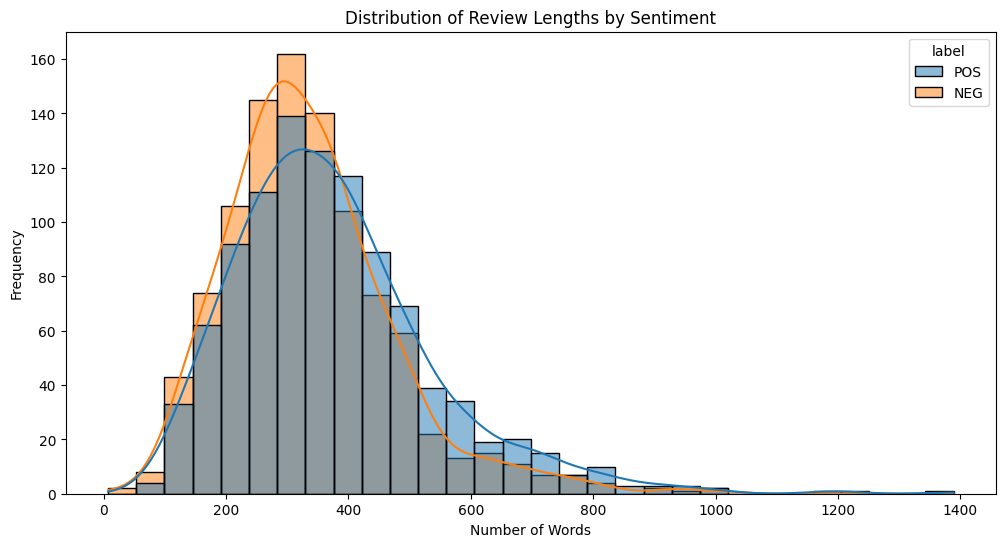

In [ ]:
# Plotting review length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=review_data, x='length', hue='label', kde=True, bins=30)
plt.title("Distribution of Review Lengths by Sentiment")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

This plot shows the distribution of review lengths (in words) for positive (POS) and negative (NEG) sentiments. Both distributions are right-skewed, with most reviews clustering around 200-500 words. Negative reviews have a slightly higher frequency and longer tails, indicating that negative reviews tend to be more variable in length compared to positive reviews.


###  Word Count Analysis

In [ ]:
# Separate positive and negative reviews
pos_texts = ' '.join([text for text, label in all_reviews if label == 'POS'])
neg_texts = ' '.join([text for text, label in all_reviews if label == 'NEG'])

# Get word frequency counts for each sentiment
pos_word_counts = Counter(pos_texts.split())
neg_word_counts = Counter(neg_texts.split())

# Display the most common words in positive and negative reviews
print("Top 10 Words in Positive Reviews:", pos_word_counts.most_common(10))
print("Top 10 Words in Negative Reviews:", neg_word_counts.most_common(10))

Top 10 Words in Positive Reviews: [('film', 4864), ('one', 2904), ('movie', 2389), ('like', 1718), ('story', 1214), ('also', 1200), ('films', 1199), ('good', 1193), ('even', 1174), ('time', 1171)]
Top 10 Words in Negative Reviews: [('film', 3994), ('movie', 3049), ('one', 2616), ('like', 1835), ('even', 1381), ('good', 1127), ('time', 1112), ('would', 1049), ('get', 1037), ('bad', 1018)]


In [ ]:
def plot_top_words(reviews, title):
    words = ' '.join([text for text, label in reviews if label == title]).split()
    most_common_words = Counter(words).most_common(30)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.title(f'Top 30 Words in {title} Reviews')
    plt.xticks(rotation=90)
    plt.show()

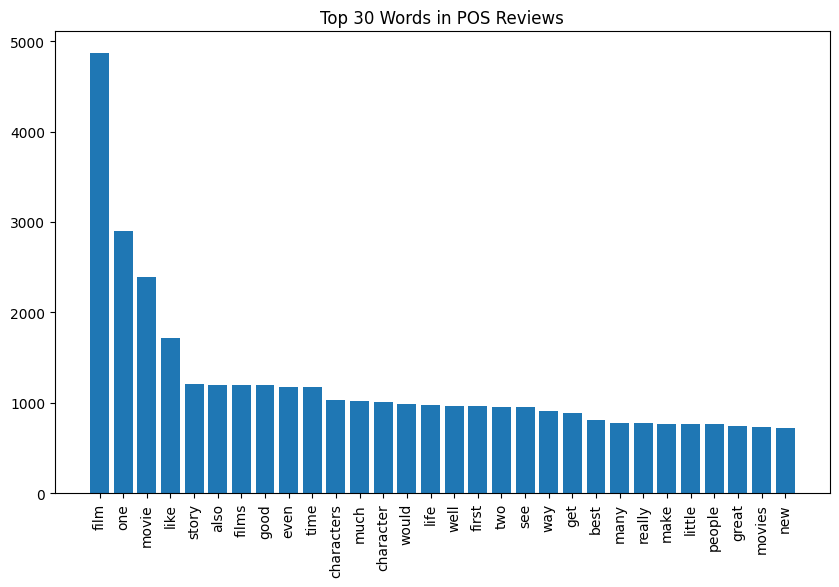

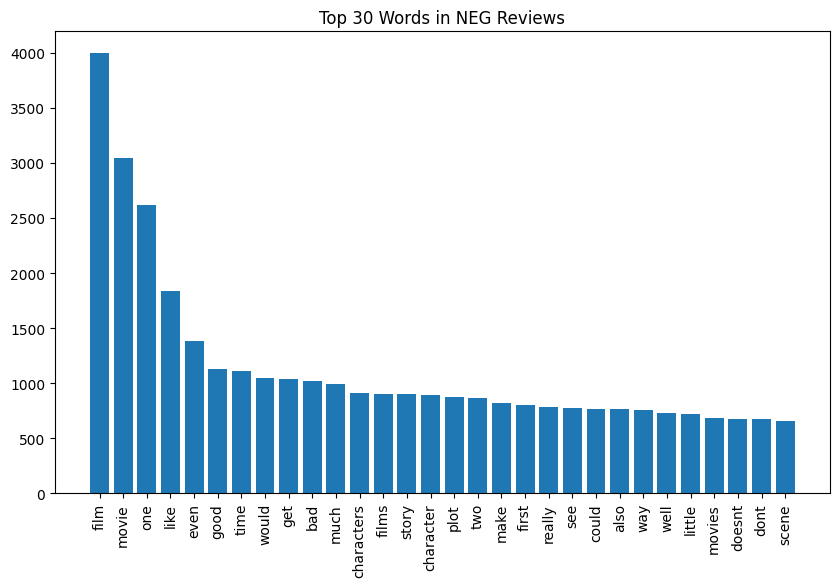

In [ ]:
plot_top_words(all_reviews, 'POS')
plot_top_words(all_reviews, 'NEG')

In both positive (POS) and negative (NEG) reviews, common words like "film," "movie," and "one" appear frequently, suggesting a general focus on the overall experience of the film rather than specific elements. However, in negative reviews, words such as "bad," "would," and "even" are more prominent, indicating a tendency to emphasize disappointment or critique specific aspects. In contrast, positive reviews show a slightly broader range of descriptive words such as "good," "like," and "story," reflecting a more favorable or engaging narrative about the film’s qualities.

### Visualizing Word Clouds for Positive and Negative Reviews

Word clouds provide a visual representation of the most frequently occurring words in each sentiment.


In [ ]:
pos_texts = ' '.join([text for text, label in all_reviews if label == 'POS'])
neg_texts = ' '.join([text for text, label in all_reviews if label == 'NEG'])

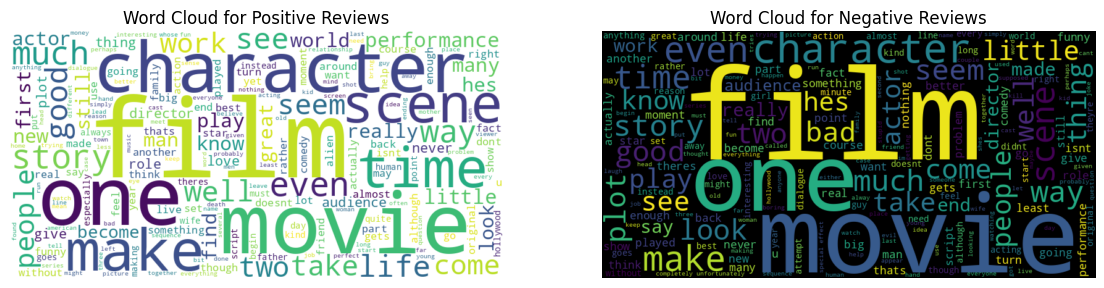

In [ ]:
# Generate word clouds
plt.figure(figsize=(14, 7))
# Word Cloud for Positive Reviews
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_texts)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")

# Word Cloud for Negative Reviews
plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(neg_texts)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Negative Reviews")

plt.show()

The word clouds for positive and negative reviews reveal distinct patterns in language usage. In positive reviews, words like "character," "story," and "scene" are prominent, suggesting that these reviews often highlight specific aspects of the film, such as characters and plot details, in a favorable light. In contrast, negative reviews also feature terms like "plot" and "character," but with additional emphasis on words such as "even," "bad," and "little," indicating a more critical tone and a tendency to point out perceived shortcomings. Both word clouds emphasize "film" and "movie," showing that these general terms are common across reviews, regardless of sentiment.








### Average Word Frequency Comparison

In [ ]:
# Combining word counts into a DataFrame for comparison
top_pos_words = dict(pos_word_counts.most_common(30))
top_neg_words = dict(neg_word_counts.most_common(30))

In [ ]:
# Merging counts, filling missing values with 0
word_df = pd.DataFrame.from_dict({'Positive': top_pos_words, 'Negative': top_neg_words}).fillna(0)

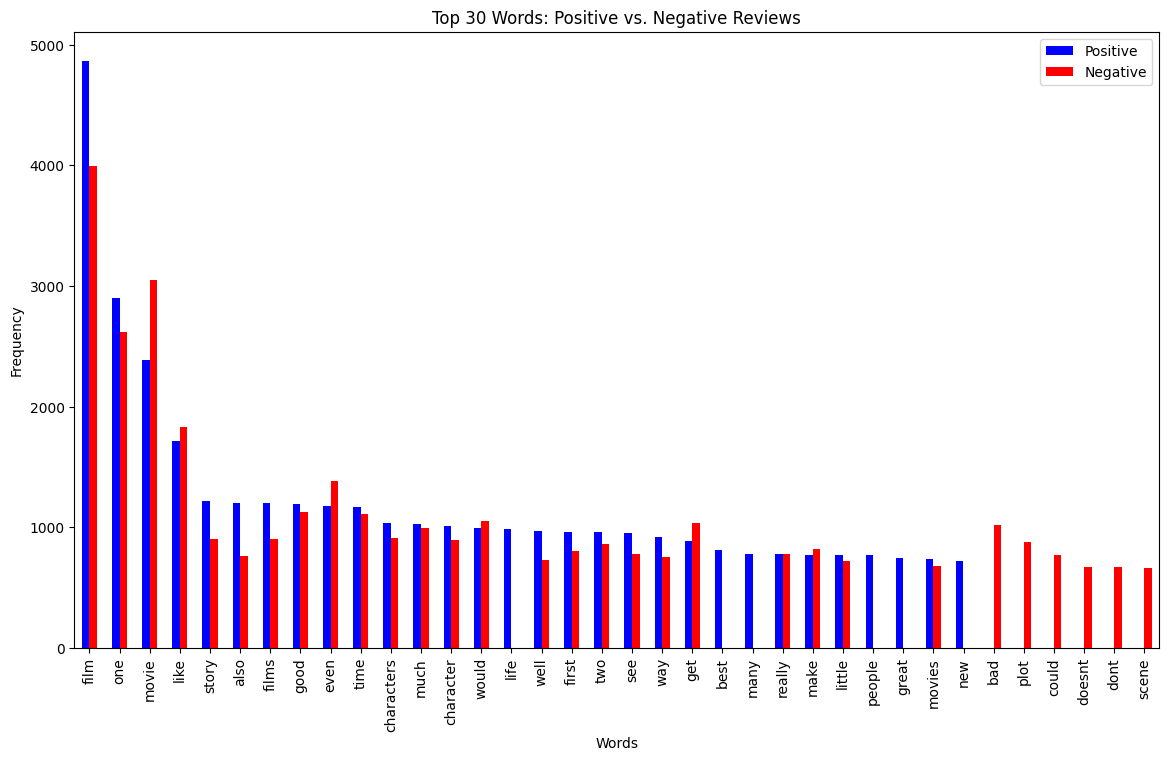

In [ ]:
word_df.plot(kind='bar', figsize=(14, 8), color=['blue', 'red'])
plt.title("Top 30 Words: Positive vs. Negative Reviews")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


While both sentiments share frequent use of general terms like "film," "movie," and "one," there are notable differences. Words like "good," "great," and "story" appear more often in positive reviews, reflecting appreciation for specific qualities. Conversely, words such as "bad," "plot," "could," and "doesn't" are more prominent in negative reviews, indicating critical perspectives on the film's narrative and execution. This contrast highlights how language usage shifts based on sentiment, with positive reviews favoring constructive descriptions and negative reviews focusing on perceived flaws.

# Data prep, spliting the data and Model Training

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)
y = labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

using naive Bayes Classifier

In [ ]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predicting on test data
y_pred = model.predict(X_test)

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='POS')
recall = recall_score(y_test, y_pred, pos_label='POS')
f1 = f1_score(y_test, y_pred, pos_label='POS')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.806
Precision: 0.82
Recall: 0.7976653696498055
F1 Score: 0.8086785009861933

Classification Report:
               precision    recall  f1-score   support

         NEG       0.79      0.81      0.80       243
         POS       0.82      0.80      0.81       257

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



### Finding the top 30 most informative words.

In [ ]:
feature_names = vectorizer.get_feature_names_out()
top_features = np.argsort(model.feature_log_prob_[1])[-30:]  # Get indices of top 30 features
informative_features = [(feature_names[i], model.feature_log_prob_[1][i]) for i in top_features]

print("Top 30 Most Informative Features:")
for feature, coef in informative_features:
    print(f"{feature}: {coef}")

Top 30 Most Informative Features:
never: -6.39784823630659
man: -6.383005663268661
great: -6.377496007457691
little: -6.3738396962545805
best: -6.3683801740496815
really: -6.3557560208212855
many: -6.334478622374
people: -6.311927796852104
make: -6.310214000374369
get: -6.181832833726163
way: -6.150696144940371
first: -6.147780690980247
well: -6.137643022695792
see: -6.123336627044554
two: -6.1106335627883
life: -6.0870704490601595
character: -6.073464797004381
would: -6.069418938484837
characters: -6.062712005228119
much: -6.028543109612869
time: -5.934878633718234
also: -5.932528456373281
good: -5.926677064604816
even: -5.9013300855174196
films: -5.9001930757303445
story: -5.887770555731787
like: -5.5532241743037885
movie: -5.2376222604081555
one: -5.0087540600119524
film: -4.509646404871923


### Classifying New Review

In [ ]:
new_review = """
There were some things I didn't like about this film. Here's what I remember most strongly:
a man in an ingeniously fake-looking polar bear costume (funnier than the "bear" from Hercules in New York);
an extra with a less than believable laugh; an ex-drug addict martian with tics; child actors who recite their lines
very slowly and carefully; a newspaper headline declaring that Santa has been "kidnapped", and a giant robot. The
least appealing acting job in the film must be when Mother Claus and her elves have been "frozen" by the "Martians'"
weapons. They seemed to display an exaggerated amount of fear. Perhaps this was the preferred acting style in the
1960's??
"""

In [ ]:
# Clean and transform new review
cleaned_review = ' '.join([word for word in re.sub(r'[^\w\s]', '', new_review.lower()).split() if word not in stop_words])
new_review_vector = vectorizer.transform([cleaned_review])

In [ ]:
# Predict sentiment
predicted_sentiment = model.predict(new_review_vector)
print(f"The predicted sentiment for the new review is: {predicted_sentiment[0]}")

The predicted sentiment for the new review is: POS


In [ ]:
predicted_sentiment

array(['POS'], dtype='<U3')

# Conclusion

In this project, we successfully constructed a Naïve Bayes classifier to gauge sentiment in movie reviews, achieving an overall accuracy of 80.6%. The model demonstrates robust performance with a precision of 82% and an F1 score of 0.81, highlighting its reliability in distinguishing between positive and negative sentiments. Key terms like "film," "one," "movie," and "like" emerged as influential in sentiment prediction, which aligns with general language usage in movie reviews.

